<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li>
</ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#!pip install --upgrade scikit-learn -q

!pip install --upgrade imbalanced-learn -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
import sklearn
from time import time

from statsmodels.tsa.seasonal import seasonal_decompose

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import root_mean_squared_error as RMSE

# классы для перебора признаков
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.impute import KNNImputer

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit



RS=42

plt.rcParams["figure.figsize"] = (18, 7)

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.sort_index(inplace=True)

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [8]:
df.isna().sum()

num_orders    0
dtype: int64

## Анализ

In [9]:
df.index.is_monotonic

True

Сначала проверим правильно ли порядке у нас хранятся значения

In [10]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [11]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Храним данные в период с начала марта по конец августа

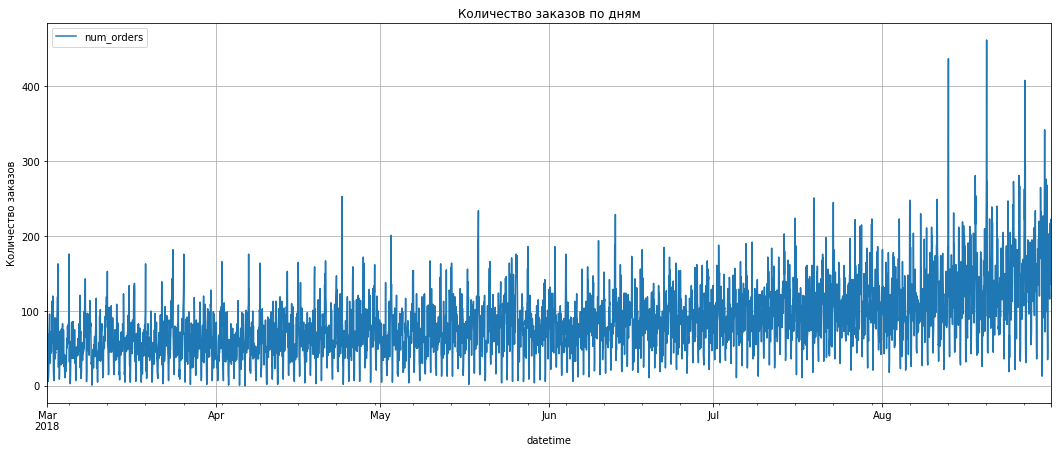

In [12]:
df.plot()
plt.grid()
plt.title('Количество заказов по дням')
plt.ylabel('Количество заказов');

Анализируя график, видно, что кол-во заказов резко увеличивается в конце августа.

Однако, стоит отметить рост в 4 квартале апреля и 3 квартале мая.

Каких-то резких спадов, не наблюдаю

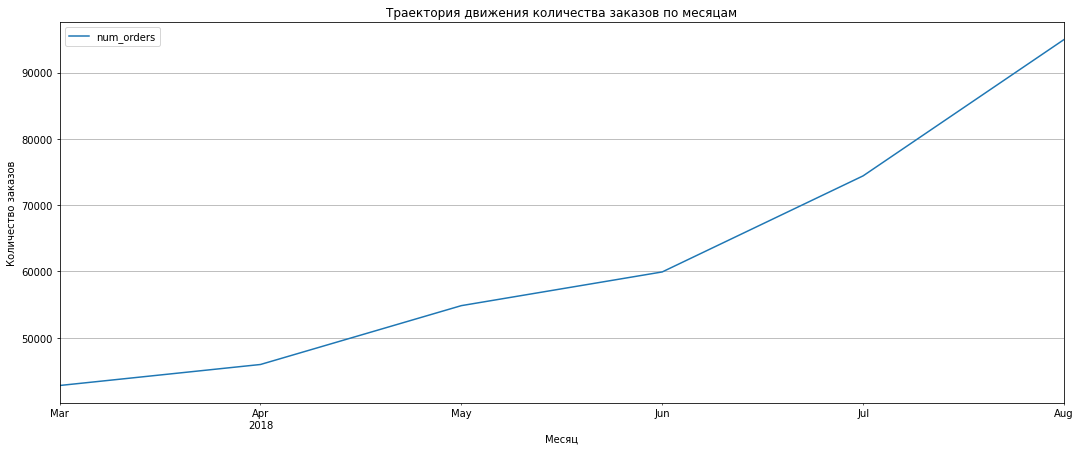

In [13]:
data = df.resample('1M').sum().plot()
plt.grid()
plt.title('Траектория движения количества заказов по месяцам')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц');

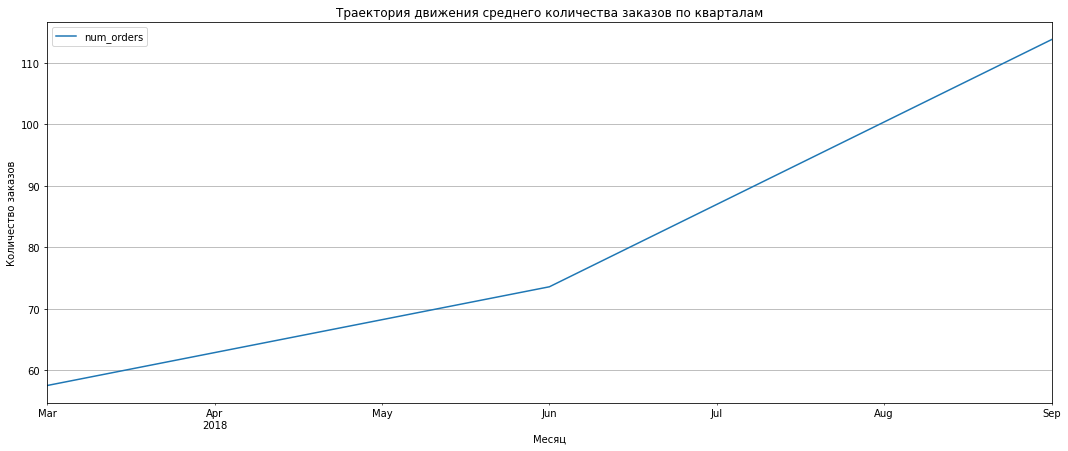

In [14]:
data = df.resample('3M').mean().plot()
plt.grid()
plt.title('Траектория движения среднего количества заказов по кварталам')
plt.ylabel('Количество заказов')
plt.xlabel('Месяц');

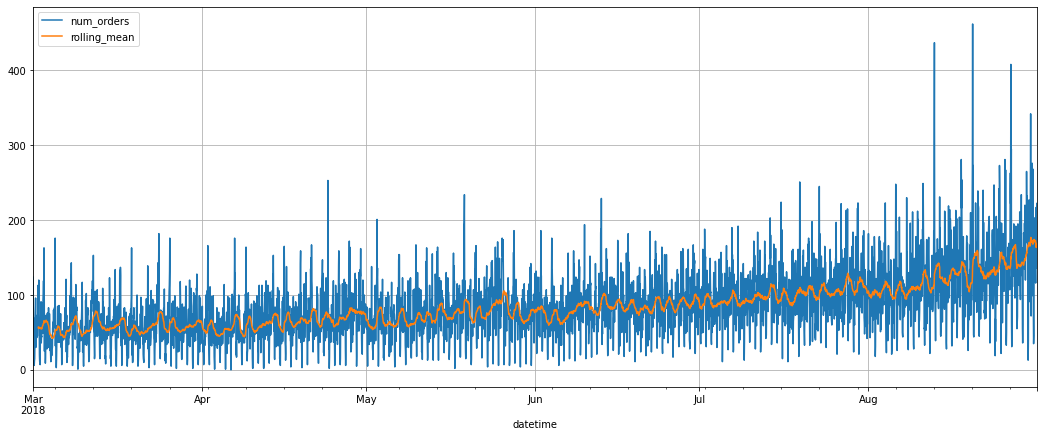

In [15]:
data = df.copy()
data['rolling_mean'] = data.rolling(24).mean()
data.plot()
plt.grid();

График с наложенным усредненным по дня значением


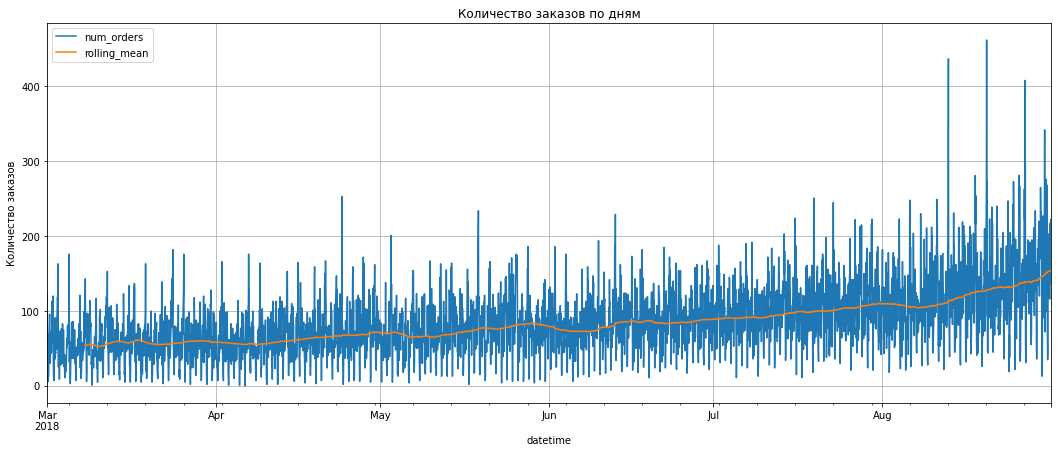

In [16]:
data = df.copy()
data['rolling_mean'] = data.rolling(168).mean()
data.plot()
plt.grid()
plt.title('Количество заказов по дням')
plt.ylabel('Количество заказов');

График с наложенным недельным усреднением

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [18]:
decomposed = seasonal_decompose(df[f'{df.index.min()}':f'{df.index.max()}']) 

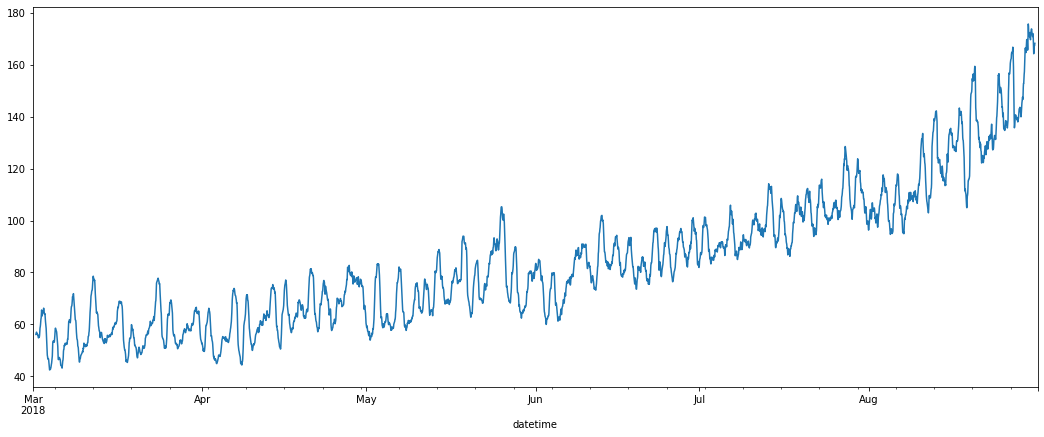

In [19]:
decomposed.trend.plot(ax=plt.gca());

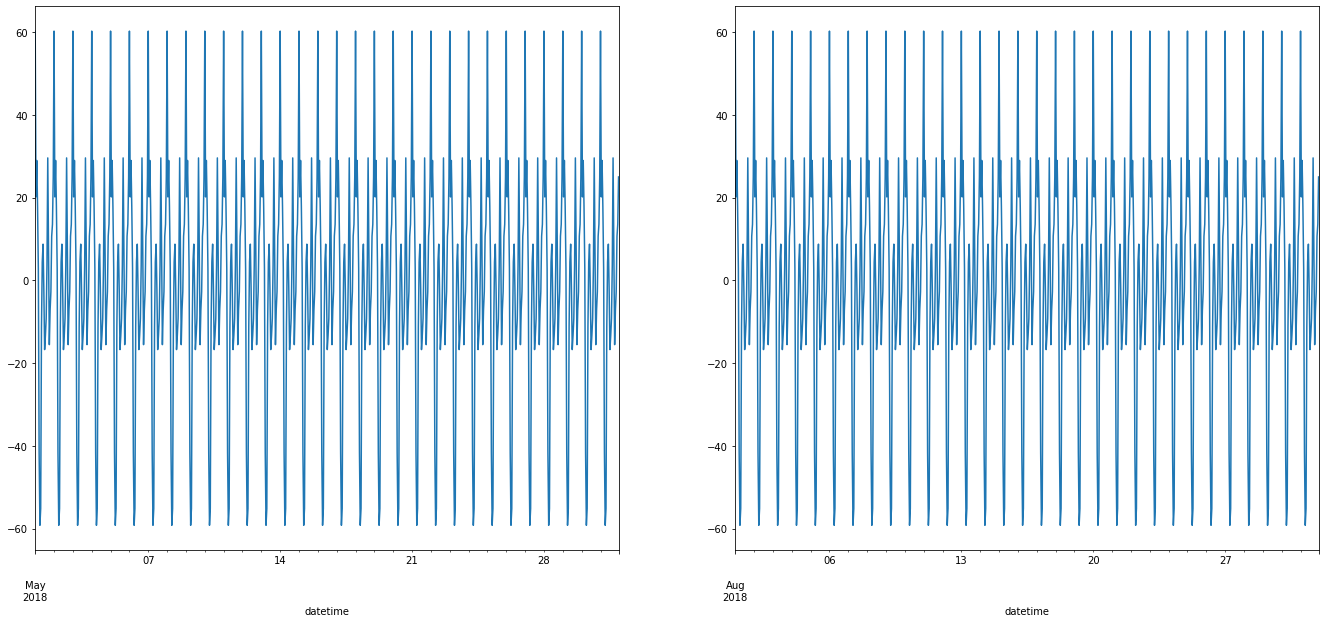

In [20]:
plt.figure(figsize=(23, 10))
plt.subplot(1,2,1)
decomposed.seasonal['2018-05-01':'2018-05-31'].plot(ax=plt.gca())

plt.subplot(1,2,2)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())

plt.show()

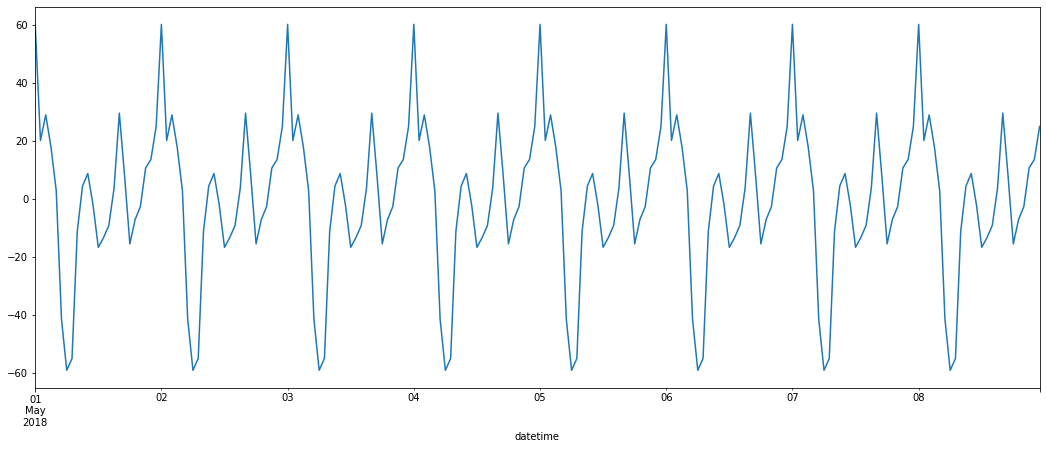

In [21]:
decomposed.seasonal['2018-05-01':'2018-05-08'].plot(ax=plt.gca());

Проверка сезонности по неделям

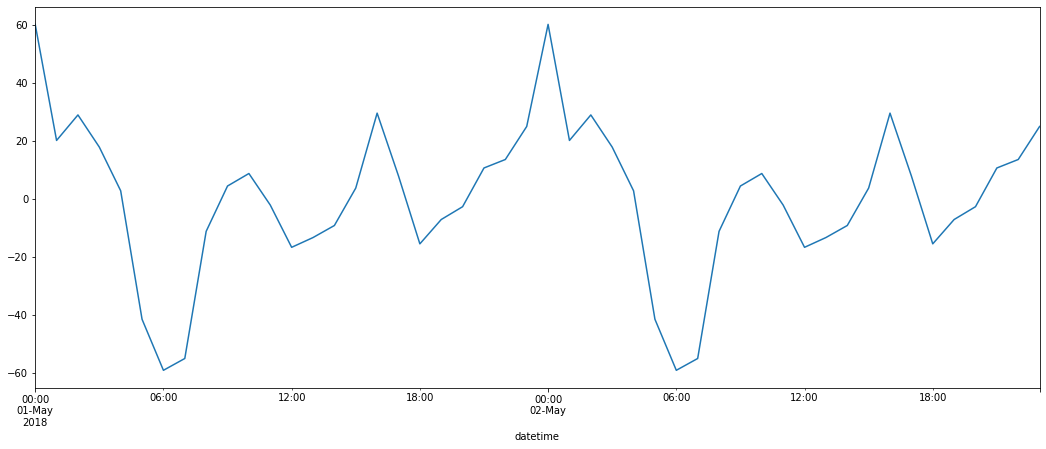

In [22]:
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(ax=plt.gca());

Проверка сезонности по суткам

### Вывод

Провел предобработку и анализ данных. Изучил общую информацию, временное начало и конец наблюдений в данных. Добавил новые признаки на основе имеющихся данных.

по графикам видно, что Тренд увеличивается в августе, т.е. растет с марта по август. Видно, что есть четкая сезонность внутри суток и недельная сезонность

## Обучение

In [23]:
def create_features(data, max_lag=1, windos_size=1):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(windos_size).mean()
        
    return data

In [24]:
df = create_features(df, 24, 24)
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()

In [26]:
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)

y_train = train['num_orders']
y_test = test['num_orders']

In [27]:
[*df.columns]

['num_orders',
 'dayofweek',
 'hour',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'rolling_mean']

In [27]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ['hour', 'dayofweek']),
        ('num', StandardScaler(), [*df.columns][3:])  
    ],
    remainder='passthrough'
)

param_distribution = [
     {
      'models':[RandomForestRegressor(random_state=RS)],
      'models__max_depth': range(2, 6),
      'models__max_features': range(2, 8),
      'models__n_estimators': [10, 20, 60]
    },
    {
        'models':[LinearRegression()],
    },
    {
        'models':[LGBMRegressor()],
        'models__learning_rate':[0.1, 0.5],
        'models__n_estimators':[100, 180],
        'models__max_depth':range(2, 5)
    }
]

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
rs = RandomizedSearchCV(
    pipe_final,
    param_distribution,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=RS,
    error_score='raise'
)
rs.fit(X_train, y_train)

[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] Unknown parameter: 180
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] Unknown parameter: 180
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 4
[LightGBM] [Warning] Unknown parameter: 180
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['hour',
                                                                                'dayofweek']),
                                                                              ('num',
                                                                               Standar...
                   param_distributions=[{'models': [RandomForestRegressor(random_state=42)],
                                         'models__max_depth': range(2, 6),
                                         'models__max_features': range(2, 8),
                                         'models__n_estimators': [10, 20, 60]},
                                        {'models': [LinearRegression()]},
                                        {'models': [LGBMRegressor()],
                                         'models__learning_rate': [0.1, 0.5],
                                         'models__max_depth ': range(2, 5),
                                         'models__n_estimators ': [100, 180]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [30]:
print('Лучшее значение метрики по итогам кросс-валидации', -1 * rs.best_score_)

Лучшее значение метрики по итогам кросс-валидации 25.479242442540198


In [31]:
b_model = rs.best_estimator_

b_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['hour', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'rolling_mean'])])),
                ('models', LGBMRegressor(max_depth =4, n_estimators =180))])

## Тестирование

In [32]:
y_pred_LGBM = b_model.predict(X_test)

print('RMSE на тестовой: ', RMSE(y_pred_LGBM, y_test))

RMSE на тестовой:  41.2900750590178


In [33]:
model_d = DummyRegressor(strategy='mean')

model_d.fit(data_preprocessor.fit_transform(X_train), y_train)

y_pred = model_d.predict(data_preprocessor.transform(X_test))

rmse_d = RMSE(y_pred, y_test)


print('RMSE для DummyRegressor', rmse_d)

RMSE для DummyRegressor 84.6499381993622


Лучшей моделью по итогам кросс-валидации оказалась модель LigthGBM, которая достигла метрики 23.32 на тренировочной и 41.43 на тестовых данных.